Dynamics Instatiation
Dynamics Instatiation Finished
Cost Instatiation
Cost Instantiation Finished
Cost instantiation took 0.7833 seconds
Initial State:
[array([[ 1.,  0.,  0.,  1.],
       [ 0.,  1.,  0.,  1.],
       [ 0.,  0.,  1., -1.],
       [ 0.,  0.,  0.,  1.]]), array([0.  , 0.75, 1.  , 2.  , 0.  , 0.2 ])]
Start Iteration: 0 , Used Time: 0.20511819899911643
Iteration: 0 Gradient w.r.t. input: 75.0047327282267
Iteration: 0 Linearization Finished, Used Time: 1.00398839799891 Cost: 565.9925568002739
Iteration: 0 Backward Pass Finished, Used Time: 1.1223116969995317
Iteration: 0 Rollout Finished, Used Time: 1.5275972970011935 Alpha: 1.0 Cost: 298.6775459928069
Iteration: 0 Rollout and Line Search Finished, Used Time: 1.5277338970008714
Iteration 0 accepted 298.6775459928069 75.0047327282267 1.0 0.0
Start Iteration: 1 , Used Time: 1.5280941969976993
Iteration: 1 Gradient w.r.t. input: 0.9256358060659139
Iteration: 1 Linearization Finished, Used Time: 2.3405876949982485 Cost: 298.67

/home/chenghuailin/anaconda3/envs/py310/lib/python3.10/site-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


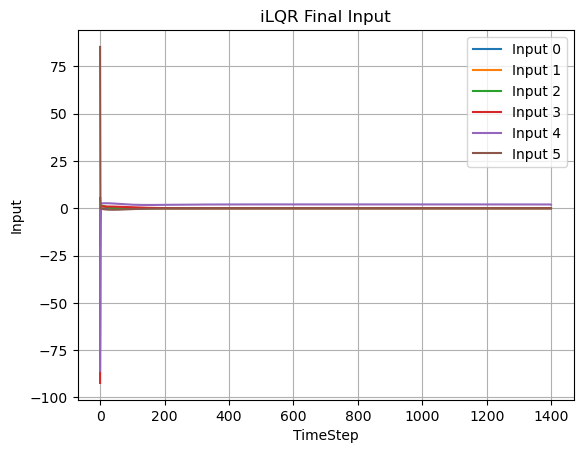

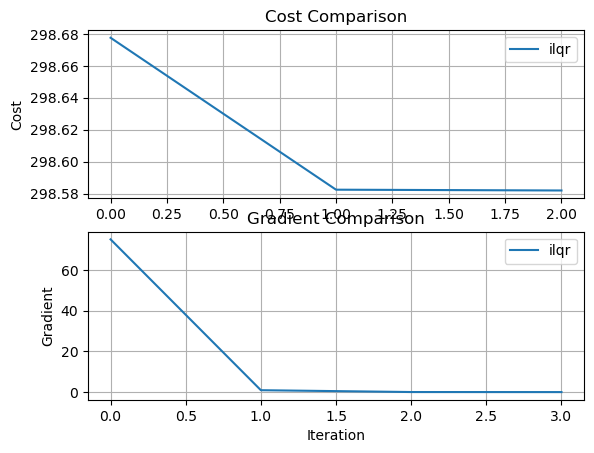

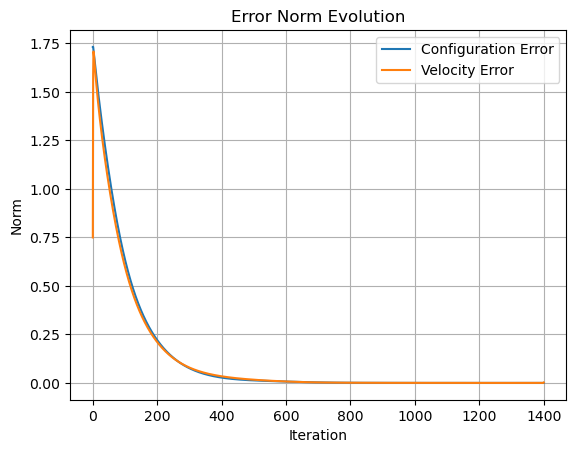

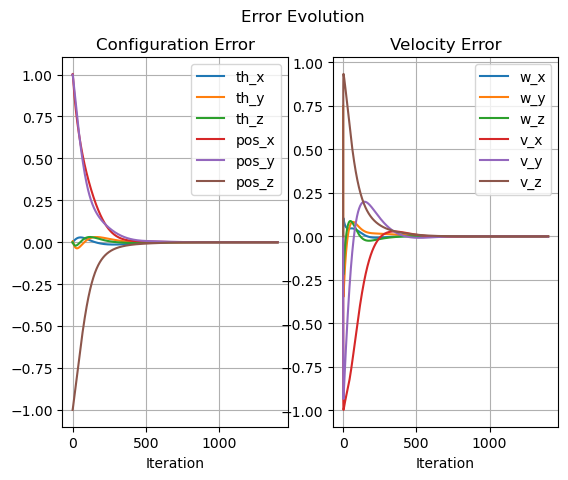

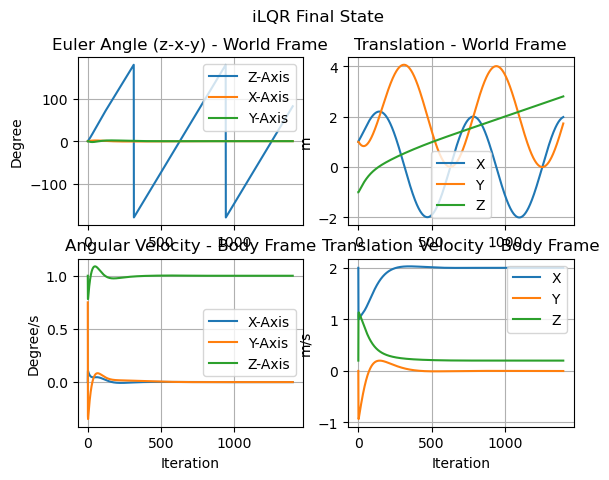

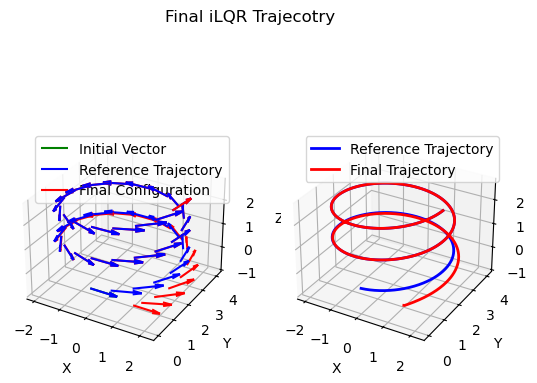

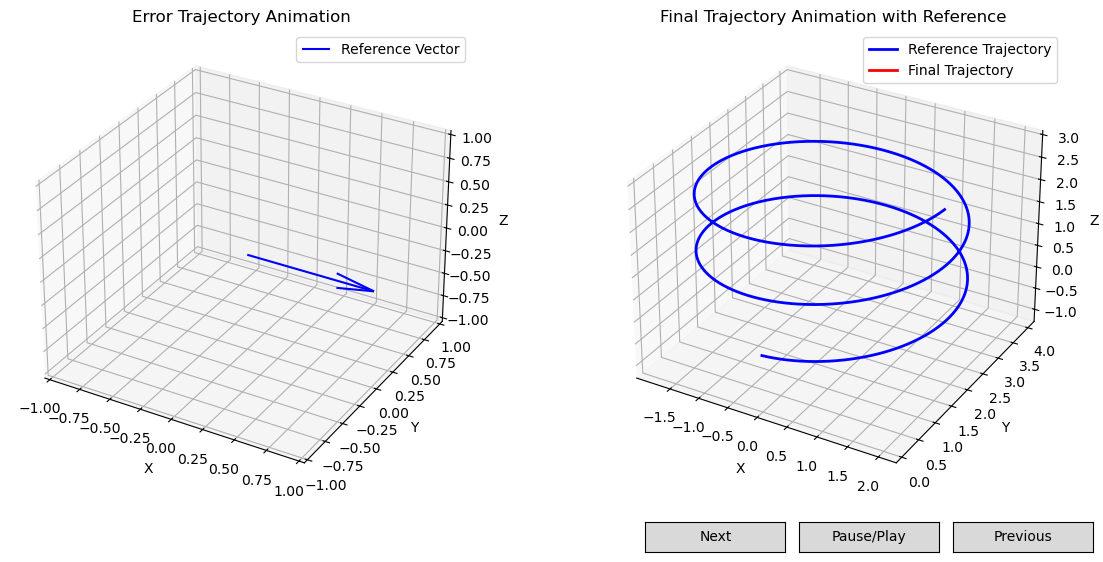

In [7]:
import jax
from traoptlibrary.traopt_controller import iLQR_Tracking_SE3
import numpy as np
from jax import random
from traoptlibrary.traopt_dynamics import SE3Dynamics
from traoptlibrary.traopt_cost import ErrorStateSE3TrackingQuadraticGaussNewtonCost
from traoptlibrary.traopt_utilis import se3_hat, quatpos2SE3, parallel_SE32manifSE3,\
    rotm2euler, manifse32se3, rotmpos2SE3
from scipy.linalg import expm
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
import time

def on_iteration(iteration_count, xs, us, J_opt, accepted, converged,grad_wrt_input_norm,
                  alpha, mu, J_hist, xs_hist, us_hist):
    J_hist.append(J_opt)
    xs_hist.append(xs.copy())
    us_hist.append(us.copy())
    info = "converged" if converged else ("accepted" if accepted else "failed")
    print("Iteration", iteration_count, info, J_opt, grad_wrt_input_norm, alpha, mu)

seed = 24234156
key = random.key(seed)
jax.config.update("jax_enable_x64", True)

dt = 0.01
Nsim = int(14/dt)   # Simulation horizon
# Nsim = 400   

# ====================
# Inertia Matrix
# ====================

m = 1
Ib = np.diag([ 0.5,0.7,0.9 ])
J = np.block([
    [Ib, np.zeros((3, 3))],
    [np.zeros((3, 3)), m * np.identity(3)]
])

# =====================================================
# Tracking Reference Generation 
# =====================================================

quat0_ref = np.array([1, 0, 0, 0])
p0_ref = np.array([0, 0, 0])
w0_ref = np.array([0, 0, 1]) * 1
v0_ref = np.array([1, 0, 0.1]) * 2

q0_ref = quatpos2SE3( np.concatenate((quat0_ref, p0_ref)) )
xi0_ref = np.concatenate((w0_ref, v0_ref))

q_ref = np.zeros((Nsim + 1, 4, 4))  # SE(3)
q_ref[0] = q0_ref
xi_ref = np.zeros((Nsim + 1, 6,)) 
xi_ref[0] = xi0_ref

X = q0_ref.copy()

for i in range(Nsim):

    xi_ref_rt = xi0_ref.copy()

    # You can try some time-varying twists here:
    # xi_ref_rt[0] = np.sin(i / 20) * 2
    # xi_ref_rt[4] = np.cos(np.sqrt(i)) * 1
    # xi_ref_rt[5] = 1  # np.sin(np.sqrt(i)) * 1

    X = X @ expm( se3_hat( xi_ref_rt ) * dt)

    # Store the reference SE3 configuration
    q_ref[i + 1] = X.copy()

    # Store the reference twists
    xi_ref[i + 1] = xi_ref_rt.copy()


# =====================================================
# Setup
# =====================================================

N = Nsim
HESSIANS = False
action_size = 6
state_size = 12
debug_dyn = {"vel_zero": False}

# =====================================================
# Dynamics Instantiation
# =====================================================

print("Dynamics Instatiation")
dynamics = SE3Dynamics(J, dt, hessians=HESSIANS, debug=debug_dyn)
print("Dynamics Instatiation Finished")

# =====================================================
# Cost Instantiation
# =====================================================

# This cost penalizes both error deviation and velocity (both on Lie algebra)

Q = np.diag([ 
    10., 10., 10., 1., 1., 1.,
    1., 1., 1., 1., 1., 1. 
])
# P = np.diag([
#     10., 10., 10., 1., 1., 1.,
#     1., 1., 1., 1., 1., 1.  
# ]) * 10

# Q = np.diag([ 
#     10., 10., 10., 1., 1., 1.,
#     0., 0., 0., 0., 0., 0. 
# ]) 
P = Q * 10
R = np.identity(6) * 1e-5

print("Cost Instatiation")
start_time = time.time() 
cost = ErrorStateSE3TrackingQuadraticGaussNewtonCost( Q, R, P, q_ref, xi_ref)
end_time = time.time() 
print("Cost Instantiation Finished")
print(f"Cost instantiation took {end_time - start_time:.4f} seconds")

# =====================================================
# Solver Instantiation
# =====================================================

# quat0 = np.array([1., 0., 0., 0.])
# p0 = np.array([-1., -1., -0.2])
# q0 = quatpos2SE3( np.concatenate((quat0, p0)) )

# w0 = np.array([0., 0., 0.1]) 
# v0 = np.array([0.1, 0.1, 0.1])

R0 = Rotation.from_euler(
    'zyx', [ 0., 0., 0. ], degrees=True
    ).as_matrix()
p0 = np.array([1., 1., -1.])
q0 = rotmpos2SE3( R0, p0 )
w0 = np.array([0., 0.75, 1.]) 
v0 = np.array([2., 0., 0.2])

xi0 = np.concatenate((w0, v0))

# quat0_ref = np.array([1, 0, 0, 0])
# p0_ref = np.array([0, 0, 0])
# w0_ref = np.array([0, 0, 1]) 
# v0_ref = np.array([2, 0, 0.2]) 

x0 = [ q0, xi0 ]
print(f'Initial State:\n{x0}')

# us_init = np.zeros((N, action_size,))
us_init = us_ilqr_good

ilqr = iLQR_Tracking_SE3(dynamics, cost, N, 
                            hessians=HESSIANS,
                            rollout='nonlinear')

xs_ilqr, us_ilqr, J_hist_ilqr, xs_hist_ilqr, us_hist_ilqr, grad_hist_ilqr = \
        ilqr.fit(x0, us_init, n_iterations=200, on_iteration=on_iteration)

# =====================================================
# Visualization Preparation
# =====================================================

err_ilqr = [cost._err(x, i) for i, x in enumerate(xs_ilqr)]

q_ilqr_mnf = parallel_SE32manifSE3([x[0] for x in xs_ilqr])
qref_ilqr_mnf = parallel_SE32manifSE3(q_ref)

norm_q_err = np.array([np.linalg.norm(err_ilqr[i][0],ord=2) for i in range( len(err_ilqr) )])
norm_vel_err = np.array([np.linalg.norm(err_ilqr[i][1],ord=2) for i in range( len(err_ilqr) )])

q_euler_ilqr = np.array([ rotm2euler(x[0][:3,:3]) for x in xs_ilqr ] )
q_xyz_ilqr = np.array([ x[0][:3,3] for x in xs_ilqr ] )
vel_euler_ilqr = np.array([ x[1][:3] for x in xs_ilqr ])
vel_xyz_ilqr = np.array([ x[1][3:] for x in xs_ilqr ])

# Extract positions from the reference and final trajectories
ref_positions = q_ref[:, :3, 3]  # Reference trajectory positions (Nsim+1, 3)
final_positions = np.array([x[0][:3, 3] for x in xs_ilqr])  # Final trajectory positions (Nsim+1, 3)

# =====================================================
# Visualization by State
# =====================================================

fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
for j in range( action_size ):
    ax1.plot( us_ilqr[:,j], label = 'Input '+str(j) )
ax1.set_title('iLQR Final Input')
ax1.set_xlabel('TimeStep')
ax1.set_ylabel('Input')
ax1.legend()
ax1.grid()

plt.figure(2)
plt.subplot(211)
plt.plot(J_hist_ilqr, label='ilqr')
plt.title('Cost Comparison')
plt.ylabel('Cost')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(grad_hist_ilqr, label='ilqr')
plt.title('Gradient Comparison')
plt.xlabel('Iteration')
plt.ylabel('Gradient')
plt.legend()
plt.grid()

plt.figure(3)
plt.plot(norm_q_err, label='Configuration Error')
plt.plot(norm_vel_err, label='Velocity Error')
plt.title('Error Norm Evolution')
plt.xlabel('Iteration')
plt.ylabel('Norm')
plt.legend()
plt.grid()

plt.figure(4)
plt.suptitle('Error Evolution')
plt.subplot(121)
for j in range(6):
    plt.plot( [err_ilqr[i][0][j] for i in range(len(err_ilqr))] )
plt.title('Configuration Error')
plt.legend(['th_x','th_y','th_z','pos_x','pos_y','pos_z'])
plt.xlabel('Iteration')
plt.grid()

plt.subplot(122)
for j in range(6):
    plt.plot( [err_ilqr[i][1][j] for i in range(len(err_ilqr))] )
plt.title('Velocity Error')
plt.legend(['w_x','w_y','w_z','v_x','v_y','v_z'])
plt.xlabel('Iteration')
plt.grid()

plt.figure(5)
plt.suptitle("iLQR Final State")

plt.subplot(221)
for i in range(3):
    plt.plot( q_euler_ilqr[:,i] )
plt.title('Euler Angle (z-x-y) - World Frame')
plt.ylabel('Degree')
plt.legend(['Z-Axis','X-Axis','Y-Axis'])
plt.grid()

plt.subplot(222)
for i in range(3):
    plt.plot( q_xyz_ilqr[:,i] )
plt.title('Translation - World Frame')
plt.ylabel('m')
plt.legend(['X','Y','Z'])
plt.grid()

plt.subplot(223)
for i in range(3):
    plt.plot( vel_euler_ilqr[:,i] )
plt.title('Angular Velocity - Body Frame')
plt.xlabel('Iteration')
plt.ylabel('Degree/s')
plt.legend(['X-Axis','Y-Axis','Z-Axis'])
plt.grid()

plt.subplot(224)
for i in range(3):
    plt.plot( vel_xyz_ilqr[:,i] )
plt.title('Translation Velocity - Body Frame')
plt.xlabel('Iteration')
plt.ylabel('m/s')
plt.legend(['X','Y','Z'])
plt.grid()


# =====================================================
# Visualization Trajectory with Vector
# =====================================================

interval_plot = int((Nsim + 1) / 40)

# Initialize the plot
fig1 = plt.figure()
plt.suptitle('Final iLQR Trajecotry')
ax1 = fig1.add_subplot(121, projection='3d')

# Define an initial vector and plot on figure
initial_vector = np.array([1, 0, 0])  # Example initial vector
ax1.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2], color='g', label='Initial Vector')

# Loop through quaternion data to plot rotated vectors
for i in range(0, Nsim + 1, interval_plot):  

    # =========== 1. Plot the reference trajectory ===========

    se3_matrix = q_ref[i]

    rot_matrix = se3_matrix[:3,:3]
    rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector
    
    # Extract the position 
    position = se3_matrix[:3, 3]

    # Plot the rotated vector
    ax1.quiver(position[0], position[1], position[2],
              rotated_vector[0], rotated_vector[1], rotated_vector[2],
              color='b', length=1, label='Reference Trajectory' if i == 0 else '')
    
    # =========== 2. Plot the simulated final configuration trajectory ===========

    # se3_matrix = q_ref[i] @ expm( se3_hat( xs_ilqr[i, :6]) )
    se3_matrix = xs_ilqr[i][0]
    
    rot_matrix = se3_matrix[:3,:3]  # Get the rotation matrix from the quaternion
    rotated_vector = rot_matrix @ initial_vector  # Apply the rotation to the initial vector

    position = se3_matrix[:3, 3]
    
    # Plot the rotated vector
    ax1.quiver(position[0], position[1], position[2],
              rotated_vector[0], rotated_vector[1], rotated_vector[2],
              color='r', length=1, label='Final Configuration' if i == 0 else '')


# lim = 5
# ax1.set_xlim([-lim, lim]) 
# ax1.set_ylim([-lim, lim])
# ax1.set_zlim([-lim, lim])
ax1.legend()
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')

ax2 = fig1.add_subplot(122, projection='3d')
ax2.plot(ref_positions[:, 0], ref_positions[:, 1], ref_positions[:, 2],
            label='Reference Trajectory', color='blue', linewidth=2)
ax2.plot(final_positions[:, 0], final_positions[:, 1], final_positions[:, 2],
            label='Final Trajectory', color='red', linewidth=2)
ax2.legend()
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

# =====================================================
# Visualization Final Trajectory with Vector as Animation
# =====================================================

import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D  # Enable 3D plotting
from matplotlib.widgets import Button
from matplotlib.lines import Line2D

# Define frame interval for smoother animation
frame_interval = 5
frames = range(0, Nsim + 1, frame_interval)

# Initialize the figure and subplots
fig_anim = plt.figure(figsize=(14, 6))
ax_anim_err = fig_anim.add_subplot(121, projection='3d')
ax_anim_traj = fig_anim.add_subplot(122, projection='3d')

# Plot the static reference trajectory
ax_anim_traj.plot(ref_positions[:, 0], ref_positions[:, 1], ref_positions[:, 2],
                 label='Reference Trajectory', color='blue', linewidth=2)

# Initialize the final trajectory line
final_traj_line, = ax_anim_traj.plot([], [], [], label='Final Trajectory', color='red', linewidth=2)

# Define an initial vector for orientation
initial_vector = np.array([1, 0, 0])

# Initialize quivers and points
ref_quiver = None
final_quiver = None
ref_point, = ax_anim_traj.plot([], [], [], 'o', color='blue', label='Reference Position')
final_point, = ax_anim_traj.plot([], [], [], 'o', color='red', label='Final Position')

# Set plot limits based on trajectories
all_positions = np.vstack((ref_positions, final_positions))
max_range = (all_positions.max(axis=0) - all_positions.min(axis=0)).max() / 2.0
mid_points = (all_positions.max(axis=0) + all_positions.min(axis=0)) * 0.5

ax_anim_traj.set_xlim(mid_points[0] - max_range, mid_points[0] + max_range)
ax_anim_traj.set_ylim(mid_points[1] - max_range, mid_points[1] + max_range)
ax_anim_traj.set_zlim(mid_points[2] - max_range, mid_points[2] + max_range)

# Set labels and title
ax_anim_traj.set_xlabel('X')
ax_anim_traj.set_ylabel('Y')
ax_anim_traj.set_zlabel('Z')
ax_anim_traj.set_title('Final Trajectory Animation with Reference')
ax_anim_traj.grid()

# Create legend
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Reference Trajectory'),
    Line2D([0], [0], color='red', lw=2, label='Final Trajectory')
]
ax_anim_traj.legend(handles=legend_elements)

# Initialize error trajectory plot
lim = 1  # Axis display range
ax_anim_err.quiver(0, 0, 0, initial_vector[0], initial_vector[1], initial_vector[2],
                  color='blue', length=1, normalize=True, label='Reference Vector')
stage_text = ax_anim_err.text2D(0.03, 0.75, "", transform=ax_anim_err.transAxes, fontsize=7)

# Set limits and labels for error plot
ax_anim_err.set_xlim([-lim, lim])
ax_anim_err.set_ylim([-lim, lim])
ax_anim_err.set_zlim([-lim, lim])
ax_anim_err.set_xlabel('X')
ax_anim_err.set_ylabel('Y')
ax_anim_err.set_zlabel('Z')
ax_anim_err.set_title('Error Trajectory Animation')
ax_anim_err.grid()
ax_anim_err.legend()

# Initialize error quivers list
error_quivers = []

# Control variables for animation
current_frame = 0
is_paused = False

def update_anim(frame):
    """Update function for the animation."""
    global ref_quiver, final_quiver, current_frame
    
    # Update final trajectory line
    traj = final_positions[:frame + 1]
    final_traj_line.set_data(traj[:, 0], traj[:, 1])
    final_traj_line.set_3d_properties(traj[:, 2])

    # Update position markers
    final_pos = traj[-1]
    final_point.set_data(final_pos[0], final_pos[1])
    final_point.set_3d_properties(final_pos[2])
    
    ref_pos = ref_positions[frame]
    ref_point.set_data(ref_pos[0], ref_pos[1])
    ref_point.set_3d_properties(ref_pos[2])
    
    # Update reference quiver
    se3_ref = q_ref[frame]
    rot_ref = se3_ref[:3, :3]
    rotated_ref_vec = rot_ref @ initial_vector
    pos_ref = se3_ref[:3, 3]
    
    if ref_quiver:
        ref_quiver.remove()
    ref_quiver = ax_anim_traj.quiver(
        pos_ref[0], pos_ref[1], pos_ref[2],
        rotated_ref_vec[0], rotated_ref_vec[1], rotated_ref_vec[2],
        color='blue', length=0.5, normalize=True
    )
    
    # Update final quiver
    se3_final = xs_ilqr[frame][0]
    rot_final = se3_final[:3, :3]
    rotated_final_vec = rot_final @ initial_vector
    pos_final = se3_final[:3, 3]
    
    if final_quiver:
        final_quiver.remove()
    final_quiver = ax_anim_traj.quiver(
        pos_final[0], pos_final[1], pos_final[2],
        rotated_final_vec[0], rotated_final_vec[1], rotated_final_vec[2],
        color='red', length=0.5, normalize=True
    )
    
    # Update title with current frame
    ax_anim_traj.set_title(f'Final Trajectory Animation with Reference\nFrame: {frame}/{Nsim}')
    
    # ------------------------------------------------------------------

    # Update error quivers
    while error_quivers:
        quiv = error_quivers.pop()
        quiv.remove()
    
    se3_error = (qref_ilqr_mnf[frame].inverse() * q_ilqr_mnf[frame]).transform()
    rot_error = se3_error[:3, :3]
    rotated_error_vec = rot_error @ initial_vector
    pos_error = se3_error[:3, 3]
    
    err_quiver = ax_anim_err.quiver(
        pos_error[0], pos_error[1], pos_error[2],
        rotated_error_vec[0], rotated_error_vec[1], rotated_error_vec[2],
        color='red', length=1, normalize=True,
        label='Error Trajectory' if frame == frames[0] else ""
    )
    error_quivers.append(err_quiver)

    lminus_error = manifse32se3( q_ilqr_mnf[frame].lminus( qref_ilqr_mnf[frame] ))
    rminus_error = manifse32se3( q_ilqr_mnf[frame].rminus( qref_ilqr_mnf[frame] ))
    lminus_error_norm = np.linalg.norm(lminus_error,ord=2)
    rminus_error_norm = np.linalg.norm(rminus_error,ord=2)

    # Update title with current frame
    ax_anim_err.set_title(f'Error Trajectory Animation\nFrame: {frame}/{Nsim}')
    
    # Update stage annotation
    stage_text.set_text(f'Left-Error Norm:{lminus_error_norm}\n  {lminus_error}\
                        \nRight-Error Norm:{rminus_error_norm}\n  {rminus_error}')

    # ------------------------------------------------------------------

    # Update frame index
    current_frame = frame
    
    return final_traj_line, ref_quiver, final_quiver, ref_point, final_point, err_quiver, stage_text

# Create the animation
ani_final_traj = animation.FuncAnimation(
    fig_anim, 
    update_anim, 
    frames=frames,
    blit=False,
    interval=0.01,  # Time between frames in milliseconds
    repeat=True    # Repeat the animation indefinitely
)


# Add interactive buttons
# Pause/Play Button
ax_pause = plt.axes([0.7, 0.01, 0.1, 0.05])
btn_pause = Button(ax_pause, 'Pause/Play')

# Previous Frame Button
ax_prev = plt.axes([0.81, 0.01, 0.1, 0.05])
btn_prev = Button(ax_prev, 'Previous')

# Next Frame Button
ax_next = plt.axes([0.59, 0.01, 0.1, 0.05])
btn_next = Button(ax_next, 'Next')

def toggle_pause(event):
    """Toggle pause/play of the animation."""
    global is_paused
    if is_paused:
        ani_final_traj.event_source.start()
    else:
        ani_final_traj.event_source.stop()
    is_paused = not is_paused

def prev_frame(event):
    """Go to the previous frame."""
    global current_frame
    if current_frame > 0:
        current_frame = max(0, current_frame - frame_interval)
        update_anim(current_frame)
        plt.draw()

def next_frame(event):
    """Go to the next frame."""
    global current_frame
    if current_frame < Nsim:
        current_frame = min(Nsim, current_frame + frame_interval)
        update_anim(current_frame)
        plt.draw()

# Connect buttons to their callback functions
btn_pause.on_clicked(toggle_pause)
btn_prev.on_clicked(prev_frame)
btn_next.on_clicked(next_frame)


# # =====================================================
# # Plotting Display
# # =====================================================

plt.show()

In [5]:
us_ilqr_good = us_ilqr.copy()